# COSC2673 - Machine Learning
# Assignment 2
## Group Name - The Puzzle's
### Student Name - Akash Hirani (s3758654)
###                           Pranav Malaviya (s3752685)

### Reading data

In [1]:
import zipfile
with zipfile.ZipFile('./Image_classification_data.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('./data_labels_mainData.csv')
data.head()

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0


#### Check for null values.

In [3]:
data.isnull().sum()

InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
dtype: int64

There are no null values found in the given dataset.
#### Let's look at the distribution of cellType

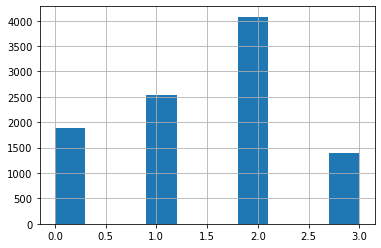

In [4]:
data.cellType.hist()
plt.show()

#### A stacked bar chart to understand the relationship between the two target variables.

<AxesSubplot:xlabel='isCancerous'>

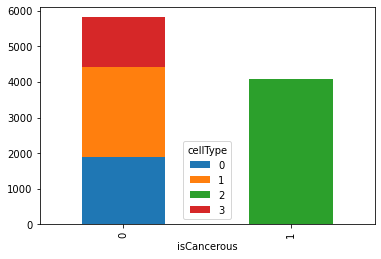

In [6]:
temp = data.groupby(['isCancerous','cellType'])['isCancerous'].count().unstack('cellType')
temp.plot(kind = 'bar',stacked = True)

The above graph manifests that all the cells that are cancerous are of type 2 in this dataset.
Let's have a look at the cell type names associated with the cellType labels.

In [7]:
set(list(zip(data["cellType"],data["cellTypeName"])))

{(0, 'fibroblast'), (1, 'inflammatory'), (2, 'epithelial'), (3, 'others')}

#### Split the dataset into train, validation and test datasets.

In [8]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 5937, Val Data: 1979, Test Data: 1980


#### Define a function to plot train and validations loss and categorical accuracy for a given model. 

In [9]:
import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

#### Declare initial parameters.
Since the size of the images given for processing is 27x27 we dclare input dimensions as (27,27,3) and there are 4 classes of the target variable cellType hene we define output_classes as 4

In [10]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 4

In [11]:
#! pip install tensorflow
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

tf.__version__

'2.4.1'

#### Determination of Goals.
So far from EDA we can see that we have biased distribution of classes as the dataset consist of higher number of class 2 samples compared to other classes especially class 3. Based on our reference to the original research from where the dataset has been derived, Metrics such as precision, recall and f1 score (weighted f1 score) were for performance evaluation of models where the highest f1-score in classification of cell type was found to be 0.80. On visiting other articles, the maximum accuracy was noted in the CNN found in the article "Two Ensemble-CNN Approaches for Colorectal Cancer Tissue Type Classification" where the accuracy achieved was 87% and f1-score of 0.87 was noted. Based on these values and the fact that the original dataset was 500x500 pixels but the one we are using is only 27x27 pixels we set our target f1 to be 0.70 or an accuracy of 75%.

#### First we tried basic sequential keras model to get a better understanding of neural networks.

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2187)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               560128    
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1028      
Total params: 561,156
Trainable params: 561,156
Non-trainable params: 0
_________________________________________________________________


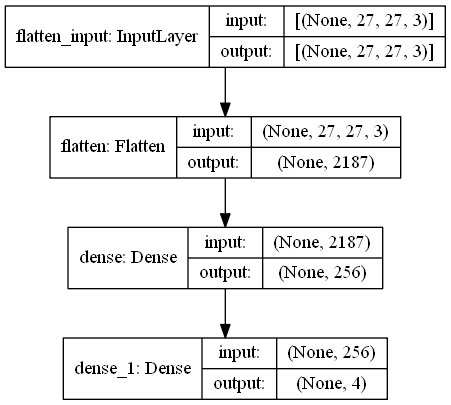

In [14]:
#! pip install pydot
#! pip install graphviz
tf.keras.utils.plot_model(model, show_shapes=True)

#### We will use CategoricalCrossentropy for this particular problem since this is a multi-class classification problem.

In [15]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [16]:
train_data['cellType'] = train_data['cellType'].astype('str')
val_data['cellType'] = val_data['cellType'].astype('str')

#### Since the image size is small we use keras ImageDataGenerator as a common regularisation technique for all our models to rescale the images as this data augmentation would help our models train better.

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


In [18]:
#fit the model
history = model.fit_generator(train_generator, validation_data = validation_generator, epochs=100, verbose=0)

C:\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


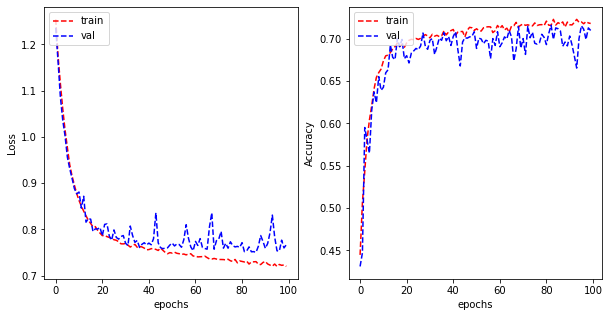

In [19]:
#plot learning curve
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

#### rescale test data as well and use a batch size of 1 so as to test 1 image at a time.

In [20]:
test_data['cellType'] = test_data['cellType'].astype('str')

test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 1980 validated image filenames belonging to 4 classes.


<ipython-input-20-1c71aa5079a5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['cellType'] = test_data['cellType'].astype('str')


In [21]:
model.evaluate(test_generator)

1980/1980 [==============================] - 3s 2ms/step - loss: 0.8095 - categorical_accuracy: 0.6949


[0.8095235824584961, 0.6949495077133179]

In [22]:
label_names = {'fibroblast' : 0, 'inflammatory' : 1, 'epithelial' : 2, 'others' : 3}

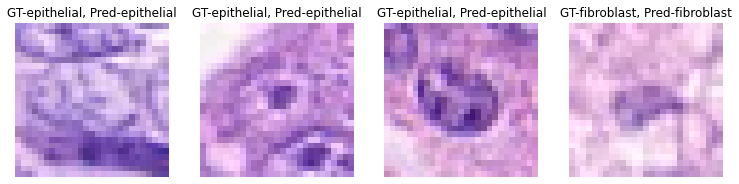

In [23]:
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(16,4))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = model.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

### Default Baseline Model
After taking GoogleNet, ResNet and VGG in consideration as our baseline model, we found out that GoogleNet and ResNet have architectures that are way more complex than VGG. Even though VGG is more expensive computationally, we realise that since we have smaller image sizes it would not affect our task significantly as we will need only fewer layers in VGG compared to it's original architechture that was designed for higher resolution (224x224) images.

On further detailed study of the structure of the VGG, we notice that it consists of many blocks (A block consists of: convolution + activation + pooling). Those blocks will lead to downscaling of the image due to the use of the max pooling layer. In the original VGG, there are many such blocks because the input image size is 224x224. What we can do is use only a few VGG blocks to construct the network. 

First we create a VGG with 3 blocks
We use softmax as activation function in the final layer as it was used by the owner of the dataset in their research article and also, softmax is effcient for us as this is a multi-class classification and we need the model to be able to give probability of each class while making predictions to be able to implement semi-supervised learning in forth-coming stages.

In [29]:
model_VGG_1 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES,activation = 'softmax'),
])

- VGG has 3x3 convolution kernels only.
- Pooling is always max-pooling and they are (2x2).
- Padding is same - No boarder pixels lost when applying convolutions. 
- activation is softmax

Lets compile the model and fit.

In [30]:
model_VGG_1.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [31]:
history_VGG_1 = model_VGG_1.fit_generator(train_generator, validation_data = validation_generator, epochs=25, verbose=0)

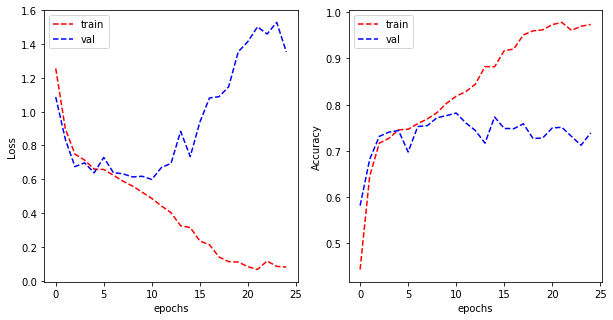

In [32]:
plot_learning_curve(history_VGG_1.history['loss'], history_VGG_1.history['val_loss'], 
                    history_VGG_1.history['categorical_accuracy'], history_VGG_1.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [33]:
model_VGG_1.evaluate(test_generator)

1980/1980 [==============================] - 4s 2ms/step - loss: 1.4451 - categorical_accuracy: 0.7288


[1.4450849294662476, 0.728787899017334]

Since the above model is overfitting we try using l2 regularisation and dropout in the next incremental model.

In [34]:
reg_lambda = 0.001

model_VGG_2 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(OUTPUT_CLASSES,activation = 'softmax'),
])

In [35]:
model_VGG_2.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

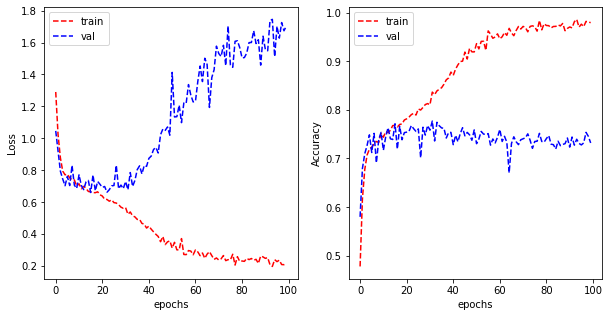

In [36]:
history_VGG_2 = model_VGG_2.fit_generator(train_generator, validation_data = validation_generator, epochs=100, verbose=0)

plot_learning_curve(history_VGG_2.history['loss'], history_VGG_2.history['val_loss'], 
                    history_VGG_2.history['categorical_accuracy'], history_VGG_2.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [37]:
model_VGG_2.evaluate(test_generator)

1980/1980 [==============================] - 4s 2ms/step - loss: 1.9517 - categorical_accuracy: 0.7167


[1.9516907930374146, 0.7166666388511658]

Since there is not much change and also a littl degradation in performance of the above model we use data augmentation in our next model. We perform data augmentation using rotation of image upto 15 degrees at a time, width and height shifts and brightness variations to the model. Note that we are performing these augmentations only on training data and not on validation or test data. Let's retrain and fit the model with augmented data. Also, this model does not use dropout.

In [38]:
train_data['cellType'] = train_data['cellType'].astype('str')
val_data['cellType'] = val_data['cellType'].astype('str')

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                   rotation_range=15, width_shift_range=0.5,
                                   height_shift_range=0.5, brightness_range=[0.5,1.5])
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


In [39]:

reg_lambda = 0.001

model_VGG_3 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation = 'softmax'),
])

In [40]:
model_VGG_3.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

C:\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


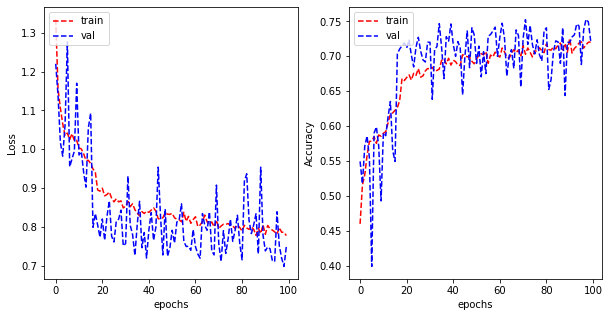

In [41]:
history_VGG_3 = model_VGG_3.fit_generator(train_generator, validation_data = validation_generator, epochs=100, verbose=0)

plot_learning_curve(history_VGG_3.history['loss'], history_VGG_3.history['val_loss'], 
                    history_VGG_3.history['categorical_accuracy'], history_VGG_3.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [42]:
model_VGG_3.evaluate(test_generator)

1980/1980 [==============================] - 4s 2ms/step - loss: 0.8089 - categorical_accuracy: 0.7222


[0.8089361786842346, 0.7222222089767456]

In [43]:
model_VGG_3.save('cellType_model_VGG_3')

INFO:tensorflow:Assets written to: cellType_model_VGG_3\assets


In [44]:
mx = tf.keras.models.load_model('cellType_model_VGG_3')

In [45]:
preds = mx.evaluate(test_generator)

1980/1980 [==============================] - 4s 2ms/step - loss: 0.8089 - categorical_accuracy: 0.7222


The above model shows significant improvement compared to it's predecessor as the loss function values decreased from 1.95 to 0.80.

To see if there is anhy improvement in the training accuracy and validation accuracy we add one more block to the VGG in the next model with all other parameters being same.

In [47]:
reg_lambda = 0.001

model_VGG_4 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 4
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation = 'softmax'),
])

In [48]:
model_VGG_4.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

C:\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


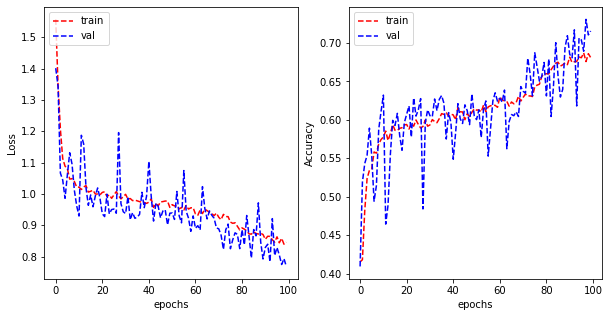

In [49]:
history_VGG_4 = model_VGG_4.fit_generator(train_generator, validation_data = validation_generator, epochs=100, verbose=0)

plot_learning_curve(history_VGG_4.history['loss'], history_VGG_4.history['val_loss'], 
                    history_VGG_4.history['categorical_accuracy'], history_VGG_4.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [50]:
model_VGG_4.evaluate(test_generator)

1980/1980 [==============================] - 8s 4ms/step - loss: 0.8324 - categorical_accuracy: 0.6970


[0.832448422908783, 0.6969696879386902]

#### The above decreases the categorcal accuracy significantly and the model starts overfitting. Hence we keep our model confined to 3 blocks only.
As an improvement measure to the model_VGG_3 we use dropout in the next model to avoid overfitting.

In [51]:

reg_lambda = 0.001

model_VGG_5 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation = 'softmax'),
])


In [52]:
model_VGG_5.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

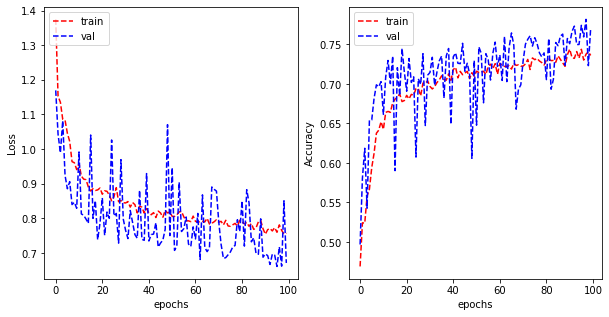

In [53]:
history_VGG_5 = model_VGG_5.fit_generator(train_generator, validation_data = validation_generator, epochs=100, verbose=0)

plot_learning_curve(history_VGG_5.history['loss'], history_VGG_5.history['val_loss'], 
                    history_VGG_5.history['categorical_accuracy'], history_VGG_5.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [54]:
model_VGG_5.evaluate(test_generator)

1980/1980 [==============================] - 4s 2ms/step - loss: 0.7562 - categorical_accuracy: 0.7470


[0.7562265396118164, 0.7469696998596191]

In [55]:
model_VGG_5.save("model_VGG_5")

INFO:tensorflow:Assets written to: model_VGG_5\assets


#### Model model_VGG_5 with l2 regularization, dropout and data augmentation is so far the best model and we have nearly reached our target categorical accuracy as it is 0.747 in this case.

### Semi-Supervised Learning
#### We are given data_labels_extraData.csv to help improve the performance of our model by using the unlabeled data.
We can use this unlabeled data as augmentation to our existing model by following these steps.
1. We use our best model so far to predict labels for the unlabeled data.
2. Then we check the prediction probabilities i.e, how much certain the model is about it's predictions of the unlabeled data.
3. We set 0.99 as our threshold of prediction probabilities to filter the samples we want to augment to our training dataset.
4. Now we combine our training data with the new data labeled by our trained model.
5. We use this new training data to train the model with same configuration again.

In [56]:
unlabeled_data = pd.read_csv('./data_labels_extraData.csv')
unlabeled_data.head()

,InstanceID,patientID,ImageName,isCancerous
0,12681,61,12681.png,0
1,12682,61,12682.png,0
2,12683,61,12683.png,0
3,12684,61,12684.png,0
4,12685,61,12685.png,0


In [128]:
# select predictions with 0.99 prediction probabilities
image_size = (27, 27)
data_to_append = pd.DataFrame()
for index,img in unlabeled_data.iterrows():
    img = tf.keras.preprocessing.image.load_img(
        "./patch_images/"+img['ImageName'], target_size=image_size
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model_VGG_5.predict(img_array)
    if max(predictions[0]) > 0.99 :
        data_to_append = data_to_append.append(unlabeled_data.loc[index],ignore_index = True)
        data_to_append.loc[index,'cellType'] = list(predictions[0]).index(max(predictions[0]))
        
data_to_append
    

,ImageName,InstanceID,isCancerous,patientID,cellType
0,12681.png,12681.0,0.0,61.0,1.0
1,12682.png,12682.0,0.0,61.0,1.0
2,12683.png,12683.0,0.0,61.0,1.0
3,12684.png,12684.0,0.0,61.0,3.0
4,12685.png,12685.0,0.0,61.0,1.0
...,...,...,...,...,...
10379,20028.png,20028.0,0.0,99.0,0.0
10380,20029.png,20029.0,0.0,99.0,0.0
10381,20030.png,20030.0,0.0,99.0,0.0
10382,20031.png,20031.0,0.0,99.0,2.0


In [129]:
# label the data according to the predictions made
label_names = {'0.0' : 'fibroblast', '1.0': 'inflammatory', '2.0':'epithelial','3.0' : 'others'}
for index, image in data_to_append.iterrows():
    data_to_append.loc[index,'cellTypeName'] = label_names.get(str(image['cellType']))
data_to_append

,ImageName,InstanceID,isCancerous,patientID,cellType,cellTypeName
0,12681.png,12681.0,0.0,61.0,1.0,inflammatory
1,12682.png,12682.0,0.0,61.0,1.0,inflammatory
2,12683.png,12683.0,0.0,61.0,1.0,inflammatory
3,12684.png,12684.0,0.0,61.0,3.0,others
4,12685.png,12685.0,0.0,61.0,1.0,inflammatory
...,...,...,...,...,...,...
10379,20028.png,20028.0,0.0,99.0,0.0,fibroblast
10380,20029.png,20029.0,0.0,99.0,0.0,fibroblast
10381,20030.png,20030.0,0.0,99.0,0.0,fibroblast
10382,20031.png,20031.0,0.0,99.0,2.0,epithelial


In [130]:
# remove null values if any
data_to_append = data_to_append.dropna().reset_index().drop(columns = 'index')

In [131]:
# combined old training data with the new labeled data
new_train_data = train_data.append(data_to_append).reset_index().drop(columns='index')

In [132]:
new_train_data.isnull().sum()

InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
dtype: int64

In [133]:
new_train_data['cellType'] = new_train_data['cellType'].astype('int')

In [134]:
set(new_train_data['cellType'])

{0, 1, 2, 3}

In [135]:
# generate training and validation data
new_train_data['cellType'] = new_train_data['cellType'].astype('str')
val_data['cellType'] = val_data['cellType'].astype('str')

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                   rotation_range=15, width_shift_range=0.5,
                                   height_shift_range=0.5, brightness_range=[0.5,1.5])
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=new_train_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 15817 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


In [136]:
# same model parameters as model_VGG_5 
reg_lambda = 0.001

model_VGG_6 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation = 'softmax'),
])


In [137]:
model_VGG_6.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

C:\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


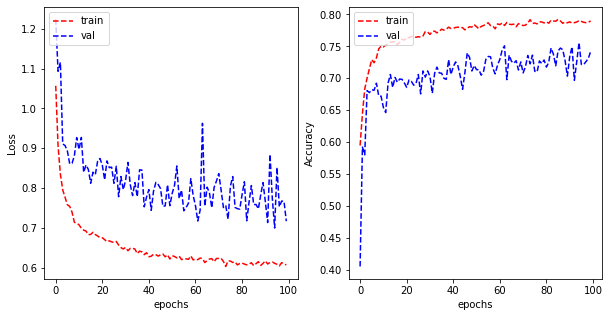

In [138]:
history_VGG_6 = model_VGG_6.fit_generator(train_generator, validation_data = validation_generator, epochs=100, verbose=0)

plot_learning_curve(history_VGG_6.history['loss'], history_VGG_6.history['val_loss'], 
                    history_VGG_6.history['categorical_accuracy'], history_VGG_6.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [139]:
model_VGG_6.evaluate(test_generator)

1980/1980 [==============================] - 5s 2ms/step - loss: 0.7698 - categorical_accuracy: 0.7419


[0.7698118090629578, 0.741919219493866]

In [140]:
model_VGG_6.save('model_VGG_6')

INFO:tensorflow:Assets written to: model_VGG_6\assets


In [193]:
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

# setup data some placeholders
y_hat_all = list()
y_all = list()
filenames = test_generator.filenames
N_images = len(filenames)
batches = 0

# iterate through the data generator and predict for each batch
# hold the predictions and labels
for x,y in test_generator:
        y_hat = model_VGG_5.predict(x, verbose=0)
        y_hat = np.argmax(y_hat, axis = 1)
        y = np.argmax(y, axis = 1)
        y_hat_all = y_hat_all + y_hat.tolist()
        y_all = y_all + y.tolist()

        batches += 1
        if batches >= N_images / batch_size:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break
            
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

print("Accuracy score: ", accuracy_score(y_all, y_hat_all))
print("F1 score: ", f1_score(y_all, y_hat_all, average='macro'))
print(confusion_matrix(y_all, y_hat_all))
print(classification_report(y_all,y_hat_all))

Found 1980 validated image filenames belonging to 4 classes.
Accuracy score:  0.746969696969697
F1 score:  0.6972288858603409
[[302  42  29  18]
 [ 58 359  57  22]
 [ 66  26 697   2]
 [ 57  80  44 121]]
              precision    recall  f1-score   support

           0       0.63      0.77      0.69       391
           1       0.71      0.72      0.72       496
           2       0.84      0.88      0.86       791
           3       0.74      0.40      0.52       302

    accuracy                           0.75      1980
   macro avg       0.73      0.69      0.70      1980
weighted avg       0.75      0.75      0.74      1980



In [194]:
y_hat_all = list()
y_all = list()
filenames = test_generator.filenames
N_images = len(filenames)
batches = 0
for x,y in test_generator:
        y_hat = model_VGG_6.predict(x, verbose=0)
        y_hat = np.argmax(y_hat, axis = 1)
        y = np.argmax(y, axis = 1)
        y_hat_all = y_hat_all + y_hat.tolist()
        y_all = y_all + y.tolist()

        batches += 1
        if batches >= N_images / batch_size:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break
            
print("Accuracy score: ", accuracy_score(y_all, y_hat_all))
print("F1 score: ", f1_score(y_all, y_hat_all, average='macro'))
print(confusion_matrix(y_all, y_hat_all))
print(classification_report(y_all,y_hat_all))

Accuracy score:  0.7419191919191919
F1 score:  0.6714931067503972
[[243  58  49  41]
 [ 17 410  29  40]
 [ 20  49 718   4]
 [ 58 108  38  98]]
              precision    recall  f1-score   support

           0       0.72      0.62      0.67       391
           1       0.66      0.83      0.73       496
           2       0.86      0.91      0.88       791
           3       0.54      0.32      0.40       302

    accuracy                           0.74      1980
   macro avg       0.69      0.67      0.67      1980
weighted avg       0.73      0.74      0.73      1980



#### Comparing the above two classification reports and confusion matrices we noticed that the model with semi supervised learning has improved predicting only class 1 and clas 2 samples (see recall and f-1 scores). Overall there is not much difference, however the supervised learning model still performs better. To investigate why only class 1 and 2 labels are prdicted better let's have a look at the following bar chart that shows the labels predicted by the supervised model on the unlabeled data that was labeled and merged to the training data.

<AxesSubplot:>

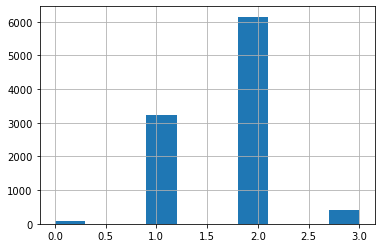

In [157]:
data_to_append.cellType.hist()

Clearly this classification is highly biased. Earlier our data had a better distribution but here since the number of samples predicted as class 1 and 2 are significantly higher the semi supervised model started overfitting and hence became less generalised and hence, resulted in higher precision, recall and f1 scores for these classes compared to that of class 0 and 3. To overcome this issue we can try to eliminating class 2 variables from the augmented data and try changing the threshold values on a class by class basis to get better results.

#### Hence our final model based on the accuracy(0.75) and f1-score (0.69) which are closest to our expectations, we elect model_VGG_5 as our final model.

In [195]:
model_VGG_5.save("cellTypeFinalModel")

INFO:tensorflow:Assets written to: cellTypeFinalModel\assets


#### Scope of Improvement
Considering the fact that we saw initially in the stacked bar graph that there was a significant relationship between the two target variables i.e, cellType and isCancerous there might be a possibility to improve our models in future if we could use the isCancerous labels as an input feature to the neural network alongside images, there might be a significant difference in our results. One way we can already think of is creating another (small) feedforward neural net alongside the CNN and then concatenating the outputs of the CNN layers and the hidden layers of the non-image neural net to each other at the dense layer. 